# Implementing a CNN in TensorFlow & Keras

Source:  
Getting started with Tensorflow and Keras. LearnOpenCV. https://learnopencv.com/Implementing-cnn-tensorflow-keras/

In [ ]:
# !pip install seaborn

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

2023-11-29 03:43:26.321933: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [4]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


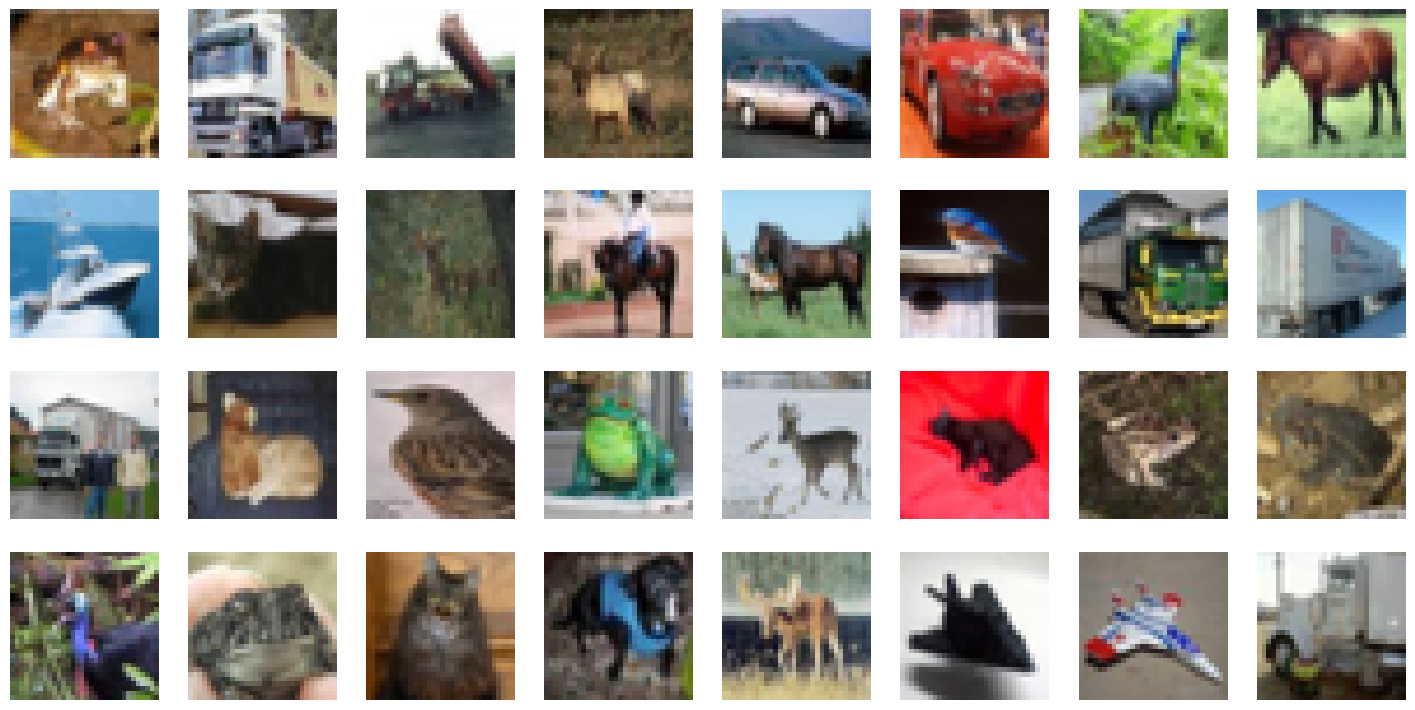

In [5]:
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 8

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    plt.axis("off")

In [6]:
# Data preprocessing

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

Original (integer) label for the first training sample:  [6]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Dataset and Training Configuration Parameters

In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

## CNN Model Implementation in Keras

In [8]:
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [9]:
# Create the model.
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

2023-11-29 03:44:31.746640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 03:44:31.752633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 03:44:31.753226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 03:44:31.754152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Number of parameters:  
* input shape: `32x32x3`  
* conv2d: 32 `3x3x3` filters => 864 weigths, 32 bias terms => 896 parameters  
* conv2d_1: 32 `3x3x32` filters => 9216 weigths, 32 bias terms => 9248 parameters  
* max_pool output: `16x16x32`

* conv2d_2: 64 `3x3x32` filters => 18432 weigths, 64 bias terms => 18496 parameters  
... and so on.

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

In [11]:
history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_split=.3,
                   )

Epoch 1/31


2023-11-29 03:45:02.193316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-29 03:45:02.839052: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 03:45:02.839568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 03:45:02.839604: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-29 03:45:02.840292: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 03:45:02.840390: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


137/137 [==============================] - 7s 28ms/step - loss: 2.0650 - accuracy: 0.2493 - val_loss: 1.7151 - val_accuracy: 0.3831
Epoch 2/31
137/137 [==============================] - 3s 21ms/step - loss: 1.6525 - accuracy: 0.4009 - val_loss: 1.4693 - val_accuracy: 0.4741
Epoch 3/31
137/137 [==============================] - 3s 21ms/step - loss: 1.4154 - accuracy: 0.4933 - val_loss: 1.2782 - val_accuracy: 0.5379
Epoch 4/31
137/137 [==============================] - 3s 21ms/step - loss: 1.2329 - accuracy: 0.5615 - val_loss: 1.2189 - val_accuracy: 0.5652
Epoch 5/31
137/137 [==============================] - 3s 21ms/step - loss: 1.0893 - accuracy: 0.6138 - val_loss: 1.1433 - val_accuracy: 0.6026
Epoch 6/31
137/137 [==============================] - 3s 21ms/step - loss: 0.9702 - accuracy: 0.6549 - val_loss: 0.9743 - val_accuracy: 0.6595
Epoch 7/31
137/137 [==============================] - 3s 21ms/step - loss: 0.8616 - accuracy: 0.6936 - val_loss: 0.9357 - val_accuracy: 0.6772
Epoch 8/31

In [12]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

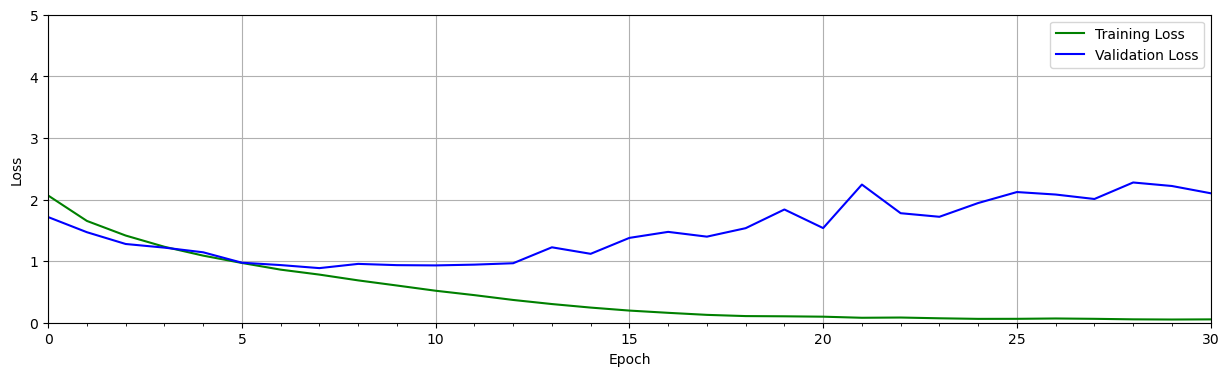

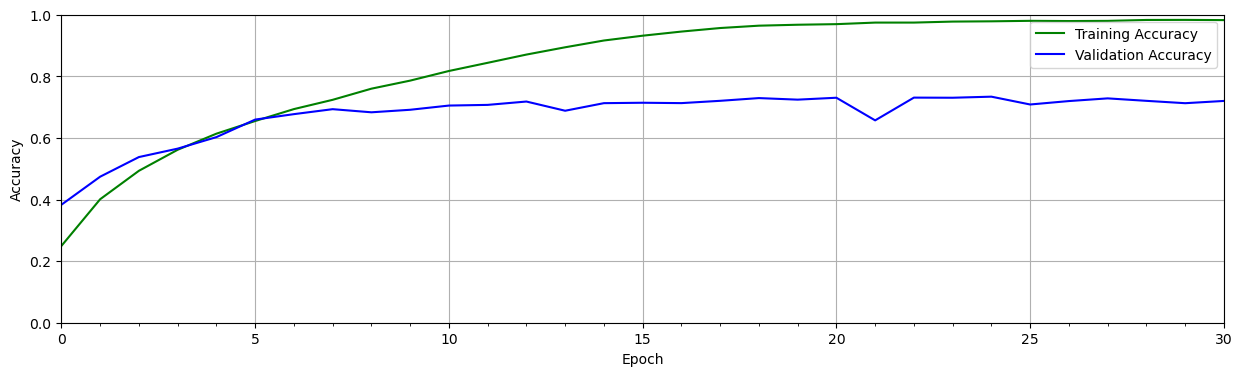

In [13]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## Adding Dropout to the Model

In [14]:
def cnn_model_dropout(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [15]:
# Create the model.
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [16]:
model_dropout.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'],
                     )

In [17]:
history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE,
                            epochs=TrainingConfig.EPOCHS,
                            verbose=1,
                            validation_split=.3,
                           )

Epoch 1/31
137/137 [==============================] - 4s 25ms/step - loss: 2.1341 - accuracy: 0.2117 - val_loss: 1.9365 - val_accuracy: 0.3332
Epoch 2/31
137/137 [==============================] - 3s 22ms/step - loss: 1.7706 - accuracy: 0.3610 - val_loss: 1.5474 - val_accuracy: 0.4385
Epoch 3/31
137/137 [==============================] - 3s 22ms/step - loss: 1.5493 - accuracy: 0.4397 - val_loss: 1.3199 - val_accuracy: 0.5233
Epoch 4/31
137/137 [==============================] - 3s 22ms/step - loss: 1.3841 - accuracy: 0.5014 - val_loss: 1.3157 - val_accuracy: 0.5302
Epoch 5/31
137/137 [==============================] - 3s 22ms/step - loss: 1.2577 - accuracy: 0.5514 - val_loss: 1.1436 - val_accuracy: 0.5860
Epoch 6/31
137/137 [==============================] - 3s 22ms/step - loss: 1.1566 - accuracy: 0.5904 - val_loss: 1.0342 - val_accuracy: 0.6303
Epoch 7/31
137/137 [==============================] - 3s 22ms/step - loss: 1.0782 - accuracy: 0.6156 - val_loss: 0.9629 - val_accuracy: 0.6605

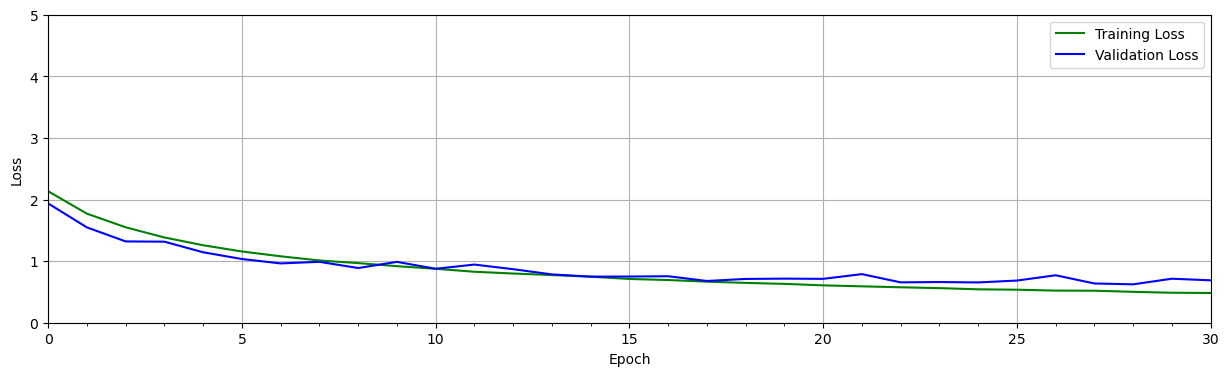

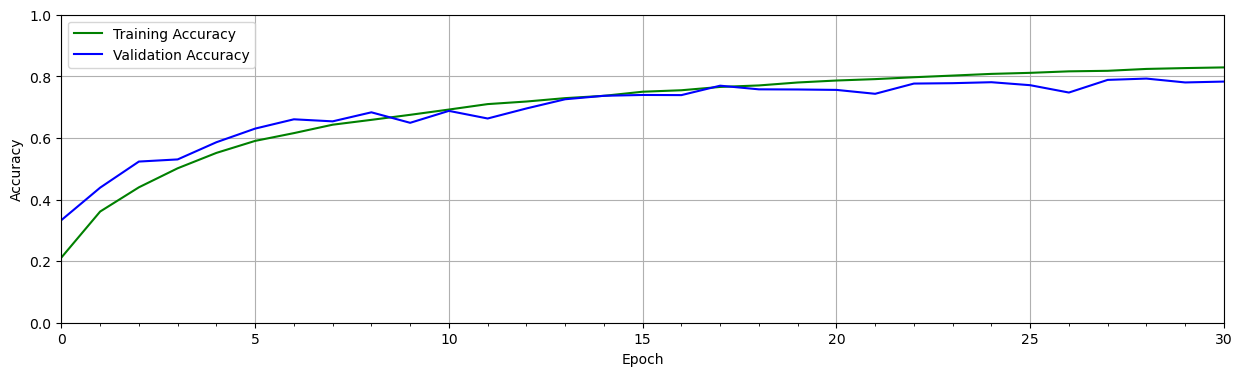

In [18]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## Saving and Loading Models

In [19]:
# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
model_dropout.save('model_dropout')

INFO:tensorflow:Assets written to: model_dropout/assets


INFO:tensorflow:Assets written to: model_dropout/assets


In [20]:
from tensorflow.keras import models
reloaded_model_dropout = models.load_model('model_dropout')

## Model Evaluation

In [21]:
test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.7267 - accuracy: 0.7767
Test accuracy: 77.670


In [22]:
def evaluate_model(dataset, model):
 
    class_names = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck' ]
    num_rows = 3
    num_cols = 6
     
    # Retrieve a number of images from the dataset.
    data_batch = dataset[0:num_rows*num_cols]
 
    # Get predictions from model.  
    predictions = model.predict(data_batch)
 
    plt.figure(figsize=(20, 8))
    num_matches = 0
         
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])
 
        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])
             
        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize':13})
             
        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
                 
        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)
     
    return

1/1 [==============================] - 0s 157ms/step
Prediction accuracy:  0.94


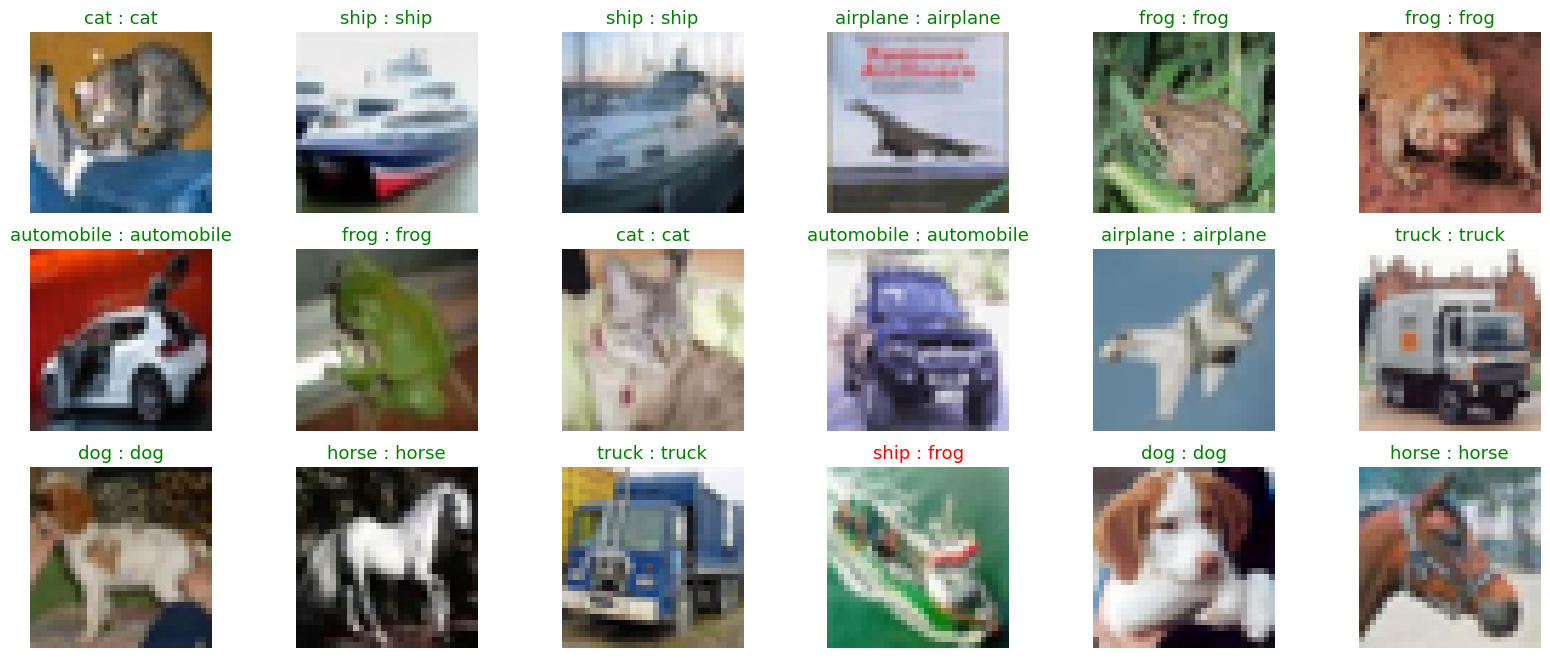

In [23]:
evaluate_model(X_test, reloaded_model_dropout)

### Confusion matrix

In [24]:
import seaborn as sn

In [25]:
# Generate predictions for the test dataset.
predictions = reloaded_model_dropout.predict(X_test)
 
# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 1s 2ms/step


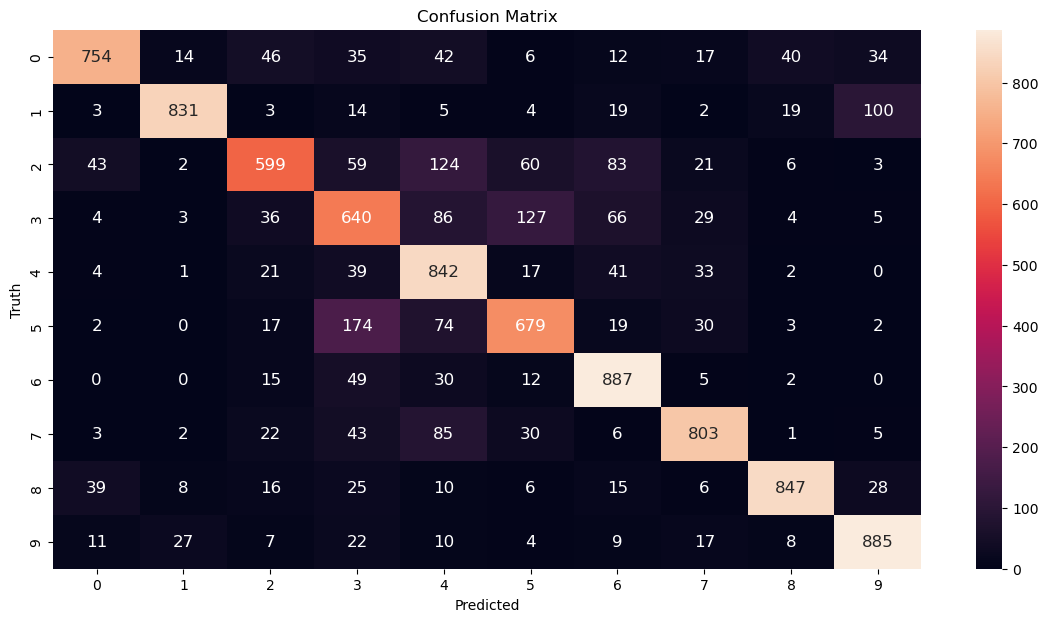

In [26]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)
 
# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)
 
# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[14, 7])

sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()